<a href="https://colab.research.google.com/github/rkorolov/dataDrivenModelingAndMachineLearning/blob/main/outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [243]:

# ============================================================
# Imports
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import statsmodels.api as sm

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)



### Q1.1 — Model choice and justification

#### Justifcations:
Why did you choose this model (Linear vs Ridge vs Lasso)?

I chose the **Linear Regression** model because Linear Regression OLS works well with implementing Cook's Distance outlier detection.

Why did you choose this library (Statsmodels vs scikit-learn)?

I chose the **Statsmodels OLS** library to take advantage of the clean influence disgnostics workflow.

In [244]:

# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())


Shape: (9568, 5)

Columns:
['AT', 'V', 'AP', 'RH', 'PE']


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90



Summary statistics:


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.618518,54.250021,1013.288871,73.308978,454.407820
std,8.256412,13.993655,6.636609,16.094499,18.760047
min,-39.174839,-38.397358,959.607298,-53.091613,327.528030
25%,13.480000,41.670000,1009.077500,63.227500,439.730000
50%,20.320000,52.080000,1012.950000,74.955000,451.620000
75%,25.732500,66.540000,1017.320000,84.882500,468.530000
max,77.344839,155.117358,1064.772702,187.691613,590.091970



Missing values per column:


,0
AT,0
V,0
AP,0
RH,0
PE,0


### Q1.2 — Identify outliers, remove them, and export clean CSV

In [245]:
# Randomly split the dataset into 70% training and 30% testing.
# Use a fixed random state for reproducibility -- seed=42.

features = ["AT", "V", "AP", "RH"]
target = "PE"

X = df[features]
y = df[target]

X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()

influence = OLSInfluence(model)
cooks_d = influence.cooks_distance[0] # compute Cook's Distance for each data point

df["cooks_distance"] = cooks_d

# identify outliers using 4/n as a threshold
n = len(df)
threshold = 4 / n

outliers = df["cooks_distance"] > threshold

df_clean = df.loc[~outliers].copy() # remove detected outliers
df_clean = df_clean.drop(columns=["cooks_distance"]) # drop distance col

df_clean.to_csv("usina.csv", index=False) # export to a new csv

## Q2 Train the above models on usina with outliers.csv and report train/test metrics.

In [246]:
# === Helper Functions ===
def eval_metrics(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return {
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2":  r2_score(y_true, y_pred),
    }

def standardized_coef_unscaled(beta, X_train_raw, y_train_raw):
    """Standardized coefficients (effect size) for unscaled data:
       beta_std = beta * (std(X)/std(y)), computed using TRAIN statistics.
    """
    std_x = np.std(X_train_raw, axis=0, ddof=0)
    std_y = float(np.std(y_train_raw, axis=0, ddof=0))
    std_y = std_y if std_y > 0 else 1.0
    return beta * (std_x / std_y)

def convert_scaled_coef_to_original(beta_scaled, intercept_scaled, x_scaler: StandardScaler, y_scaler: StandardScaler):
    """Convert coefficients from (X_scaled, y_scaled) space to original units."""
    x_mean = x_scaler.mean_
    x_std  = x_scaler.scale_
    y_mean = float(y_scaler.mean_)
    y_std  = float(y_scaler.scale_)

    beta_orig = (y_std * beta_scaled) / x_std
    intercept_orig = y_mean + y_std * intercept_scaled - np.sum((y_std * beta_scaled * x_mean) / x_std)
    return beta_orig, intercept_orig

### Train the above models on usina with outliers.csv and report train/test metrics.

In [247]:

# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)



In [248]:
# === Train/Test split (70/30) ===
features = ["AT", "V", "AP", "RH"]
target_col = "PE"

X = df.drop(columns=[target_col]).copy()
y = df[target_col].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (6697, 4) (6697, 1)
Test : (2871, 4) (2871, 1)


In [249]:
# === Create an unscaled version (scale BOTH X and y) ===
# Unscaled
X_train_un = X_train.values
X_test_un  = X_test.values
y_train_un = y_train
y_test_un  = y_test


In [250]:
# === Train Models & Report -- Outliers ===
models = {
    "Linear": LinearRegression(),
    "Ridge(lambda=0.01)": Ridge(alpha=0.01, random_state=42),
    "Ridge(lambda=0.1)":  Ridge(alpha=0.1, random_state=42),
    "Ridge(lambda=1.0)":  Ridge(alpha=1.0, random_state=42),
    "Ridge(lambda=10)":   Ridge(alpha=10, random_state=42),
    "Ridge(lambda=100)":  Ridge(alpha=100, random_state=42),
    "Lasso(lambda=0.01)": Lasso(alpha=0.01, max_iter=50000, random_state=42),
    "Lasso(lambda=0.1)":  Lasso(alpha=0.1, max_iter=50000, random_state=42),
    "Lasso(lambda=10)":   Lasso(alpha=10, max_iter=50000, random_state=42),
    "Lasso(lambda=100)":  Lasso(alpha=100, max_iter=50000, random_state=42)
}

rows_outliers = []
Xt_tr, Xt_te = X_train_un, X_test_un
yt_tr = y_train_un


for name, model in models.items():
  model.fit(Xt_tr, yt_tr.ravel())
  pred_tr = model.predict(Xt_tr).reshape(-1,1)
  pred_te = model.predict(Xt_te).reshape(-1,1)

            # Evaluate in original y-units for direct comparability
  pred_tr_eval = pred_tr
  pred_te_eval = pred_te
  yt_tr_eval = y_train_un
  yt_te_eval = y_test_un

  mtr = eval_metrics(yt_tr_eval, pred_tr_eval)
  mte = eval_metrics(yt_te_eval, pred_te_eval)

  rows_outliers.append({
    "variant": "Outliers - Unscaled",
    "model": name,
    **{f"train_{k}": v for k,v in mtr.items()},
    **{f"test_{k}": v for k,v in mte.items()},
   })


part1_results = pd.DataFrame(rows_outliers).sort_values("test_mse").reset_index(drop=True)
display(part1_results.sort_values(["variant","test_mse"]))


,variant,model,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,Outliers - Unscaled,Linear,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,Outliers - Unscaled,Ridge(lambda=0.01),123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
2,Outliers - Unscaled,Ridge(lambda=0.1),123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
3,Outliers - Unscaled,Ridge(lambda=1.0),123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
4,Outliers - Unscaled,Ridge(lambda=10),123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
5,Outliers - Unscaled,Lasso(lambda=0.01),123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
6,Outliers - Unscaled,Ridge(lambda=100),123.384213,5.199261,0.650171,125.116548,5.053003,0.642565
7,Outliers - Unscaled,Lasso(lambda=0.1),123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
8,Outliers - Unscaled,Lasso(lambda=10),126.141514,5.540418,0.642353,128.902136,5.408803,0.631750
9,Outliers - Unscaled,Lasso(lambda=100),234.655937,11.285489,0.334683,233.064336,11.258653,0.334178


### Train the same models on usina.csv and report train/test metrics.

In [251]:

# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "usina.csv"
df = pd.read_csv(DATA_PATH)


In [252]:
# === Train/Test split (70/30) ===
features = ["AT", "V", "AP", "RH"]
target_col = "PE"

X = df.drop(columns=[target_col]).copy()
y = df[target_col].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (6613, 4) (6613, 1)
Test : (2835, 4) (2835, 1)


In [253]:
# === Create an unscaled version (scale BOTH X and y) ===
# Unscaled
X_train_un = X_train.values
X_test_un  = X_test.values
y_train_un = y_train
y_test_un  = y_test


In [254]:
# === Train Models & Report -- Outliers ===
models = {
    "Linear": LinearRegression(),
    "Ridge(alpha=0.01)": Ridge(alpha=0.01, random_state=42),
    "Ridge(alpha=0.1)":  Ridge(alpha=0.1, random_state=42),
    "Ridge(alpha=1.0)":  Ridge(alpha=1.0, random_state=42),
    "Ridge(alpha=10)":   Ridge(alpha=10, random_state=42),
    "Ridge(alpha=100)":  Ridge(alpha=100, random_state=42),
    "Lasso(alpha=0.01)": Lasso(alpha=0.01, max_iter=50000, random_state=42),
    "Lasso(alpha=0.1)":  Lasso(alpha=0.1, max_iter=50000, random_state=42),
    "Lasso(alpha=10)":   Lasso(alpha=10, max_iter=50000, random_state=42),
    "Lasso(alpha=100)":  Lasso(alpha=100, max_iter=50000, random_state=42)
}

rows_no_outliers = []
Xt_tr, Xt_te = X_train_un, X_test_un
yt_tr = y_train_un


for name, model in models.items():
  model.fit(Xt_tr, yt_tr.ravel())
  pred_tr = model.predict(Xt_tr).reshape(-1,1)
  pred_te = model.predict(Xt_te).reshape(-1,1)

  # Evaluate in original y-units for direct comparability
  pred_tr_eval = pred_tr
  pred_te_eval = pred_te
  yt_tr_eval = y_train_un
  yt_te_eval = y_test_un

  mtr = eval_metrics(yt_tr_eval, pred_tr_eval)
  mte = eval_metrics(yt_te_eval, pred_te_eval)

  rows_no_outliers.append({
    "variant": "No Outliers - Unscaled",
    "model": name,
    **{f"train_{k}": v for k,v in mtr.items()},
    **{f"test_{k}": v for k,v in mte.items()},
   })

part2_results = pd.DataFrame(rows_no_outliers).sort_values("test_mse").reset_index(drop=True)
display(part2_results.sort_values(["variant","test_mse"]))


,variant,model,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,No Outliers - Unscaled,Lasso(alpha=0.1),19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
1,No Outliers - Unscaled,Ridge(alpha=100),19.864758,3.596742,0.931369,20.394626,3.624880,0.930310
2,No Outliers - Unscaled,Ridge(alpha=10),19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
3,No Outliers - Unscaled,Lasso(alpha=0.01),19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
4,No Outliers - Unscaled,Ridge(alpha=1.0),19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
5,No Outliers - Unscaled,Ridge(alpha=0.1),19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
6,No Outliers - Unscaled,Ridge(alpha=0.01),19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
7,No Outliers - Unscaled,Linear,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
8,No Outliers - Unscaled,Lasso(alpha=10),25.685683,4.086632,0.911258,26.157253,4.120464,0.910618
9,No Outliers - Unscaled,Lasso(alpha=100),132.056336,9.482307,0.543756,132.148253,9.523550,0.548436


### All metrics combined


In [255]:
df_combined = pd.concat([part1_results, part2_results], axis=0, ignore_index=True)
display(df_combined.sort_values(["test_mse"]))

,variant,model,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
10,No Outliers - Unscaled,Lasso(alpha=0.1),19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
11,No Outliers - Unscaled,Ridge(alpha=100),19.864758,3.596742,0.931369,20.394626,3.624880,0.930310
12,No Outliers - Unscaled,Ridge(alpha=10),19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
13,No Outliers - Unscaled,Lasso(alpha=0.01),19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
14,No Outliers - Unscaled,Ridge(alpha=1.0),19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
15,No Outliers - Unscaled,Ridge(alpha=0.1),19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
16,No Outliers - Unscaled,Ridge(alpha=0.01),19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
17,No Outliers - Unscaled,Linear,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
18,No Outliers - Unscaled,Lasso(alpha=10),25.685683,4.086632,0.911258,26.157253,4.120464,0.910618
0,Outliers - Unscaled,Linear,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574


### Discussion and interpretation

#### Do outliers change train error? Test error?

Outliers increase both train & test error. We can see that MSE for train and test in the no outlier case ranges from 19 to 26. In the outlier case, the train MSE range shoots up to 123 to 234 and the test MSE similiarly increases in the 125 to 234 range.


#### Which dataset (with outliers vs without outliers) shows better generalization?

The without outliers datasets shows better generalization since it haves a smaller range of error values.


#### Do Ridge/Lasso appear to help relative to standard linear regression?

In the outliers scenario, Ridge/Lasso do not appear to help and if anything they increase both train and test MSEs. (Linear has the lowest test MSE)

In the no outlier case, there appears to be a few Ridge/Lasso lambda configurations that perform marginally better than the Linear case, as seen by slightly lower MSE. Linear has the second highest test MSE.

### Q3: Reliability of Coefficients

### Q3.1 — Model choice and justification

#### Justifcations:
**Why did you choose this model (Linear vs Ridge vs Lasso)?**

I chose linear regression because coefficient reliability is most naturally and transparently evaluated in the OLS framework using standard errors, t-statistics, and p-values. Unlike Ridge or Lasso, OLS does not shrink coefficients, so uncertainty reflects the data rather than regularization bias. This makes comparisons of which coefficients are most and least reliable directly interpretable.


**Why did you choose this library (Statsmodels vs scikit-learn)?**

I chose the **Statsmodels OLS** library to take advantage of the clean influence disgnostics workflow.

**Would you scale IVs and/or DV for this coefficient reliability task?**

I would scale IVs for this coefficient reliability task because caling IVs (predictors) makes coefficient magnitudes comparable across variables and improves numerical stability, but does not change t-stats/p-values in a meaningful “evidence” sense.

**Justify your answer clearly (why scaling helps or hurts for what you want to measure).**

Scaling the IVs helps what we want to measure because it improves numerical stability of the regression and prevents coefficient magnitudes from being dominated by measurement units.

### Q3.2 — Implementation and results

In [256]:
DATA_PATH = "usina.csv"
df = pd.read_csv(DATA_PATH)

features = ["AT", "V", "AP", "RH"]
target = "PE"

X = df[features]
y = df[target]

X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()

model.summary()
results = model.summary2().tables[1]
results


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,440.999323,9.742711,45.264539,0.000000e+00,421.901513,460.097134
AT,-1.954640,0.015139,-129.113036,0.000000e+00,-1.984316,-1.924964
V,-0.237885,0.007196,-33.056481,7.527041e-227,-0.251991,-0.223778
AP,0.074638,0.009454,7.894540,3.238569e-15,0.056105,0.093171
RH,-0.148856,0.004034,-36.897303,1.578009e-278,-0.156764,-0.140947


From the table above, we see that the most reliable coefficient is AT, since it has the largest absolute-value t value of 129.11.  The least reliable coefficient is AP, which has the smallest absolute-value t value of 7.89.

### Q4: Most Important vs Least Important Features

### Q4.1 — Model choice and justification

#### Justifcations:
**Why did you choose this model (Linear vs Ridge vs Lasso)?**

I chose Linear Regression because feature importance in a linear model can be interpreted directly from the relative magnitudes of the coefficients once predictors are properly scaled. Since the goal is to compare the strength of each feature’s effect rather than perform variable selection or regularization, unregularized OLS is appropriate.

**Why did you choose this library (Statsmodels vs scikit-learn)?**

I chose Statsmodels OLS because it provides transparent access to coefficient estimates and makes it easy to interpret and report results consistently with earlier regression diagnostics.

**Would you scale IVs and/or DV for this feature importance task?**

I would scale IVs for this feature importance task, but not the DV's.

**Justify your answer clearly (why scaling helps or hurts for what you want to measure).**

Scaling the IVs is necessary for feature importance because coefficient magnitudes are otherwise dominated by the units of measurement rather than the true strength of association. Standardizing predictors places all features on the same scale, allowing coefficient magnitudes to be compared directly. Without scaling, feature importance rankings would be misleading. Scaling the DV is unnecessary because it does not affect relative comparisons among predictors.

### Q4.2 — Implementation and results

In [257]:
DATA_PATH = "usina.csv"
df = pd.read_csv(DATA_PATH)

features = ["AT", "V", "AP", "RH"]
target = "PE"

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X),
    columns=features,
    index=X.index
)

X_scaled_df = sm.add_constant(X_scaled_df)

model = sm.OLS(y, X_scaled_df).fit()

results = model.summary2().tables[1]
results




,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,454.299681,0.046048,9865.883727,0.000000e+00,454.209418,454.389944
AT,-14.556614,0.112743,-129.113036,0.000000e+00,-14.777614,-14.335613
V,-3.030737,0.091684,-33.056481,7.527041e-227,-3.210457,-2.851018
AP,0.442513,0.056053,7.894540,3.238569e-15,0.332637,0.552389
RH,-2.197120,0.059547,-36.897303,1.578009e-278,-2.313845,-2.080395


From the above output, we can see that the most important feature is AT and the least important feature is AP -- which we get from looking at the magnitude of the standarized coefficients.

### Q5: Regularization Paths

In [258]:
# ==== Load & Scale
df = pd.read_csv("usina.csv")

features = ["AT", "V", "AP", "RH"]
target = "PE"

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [259]:
# ==== Create a lambda range
lambdas = np.logspace(-4, 3, 100)


In [260]:
# ==== For each Lambda, fit models & record coeff values
ridge_coefs = []
lasso_coefs = []

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)

    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)


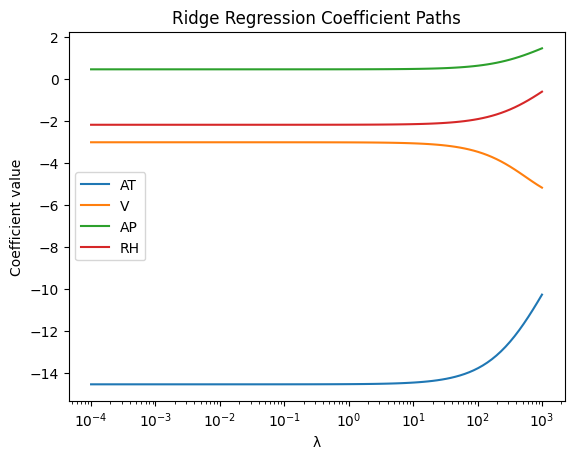

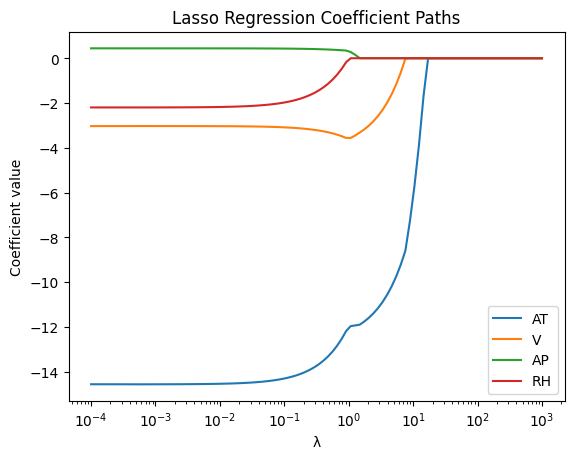

In [261]:
# ==== Plot coef value vs lambda

# ridge plot
plt.figure()
for i, feature in enumerate(features):
    plt.plot(lambdas, ridge_coefs[:, i], label=feature)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression Coefficient Paths")
plt.legend()
plt.show()

# lasso plot
plt.figure()
for i, feature in enumerate(features):
    plt.plot(lambdas, lasso_coefs[:, i], label=feature)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression Coefficient Paths")
plt.legend()
plt.show()


### Discussion and interpretation

#### What happens to coefficients as λ increases in Ridge vs Lasso?

As λ increases in **Ridge regression**, all coefficients are gradually shrunk toward zero, but none are driven exactly to zero. Ridge reduces coefficient magnitude continuously while retaining all predictors in the model.

As λ increases in **Lasso regression**, coefficients are shrunk and several are driven exactly to zero. This produces sparse models in which less important features are removed entirely.

#### Which regression is better under multicollinearity in IVs, and why?

**Ridge regression** is better under multicollinearity because the L2 penalty shrinks correlated predictors together rather than eliminating them.


#### Which regression is better for feature selection, and why?

**Lasso regression** is better for feature selection because the L1 penalty drives some coefficients exactly to zero as λ increases, effectively removing less important predictors from the model.